In [2]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys
from datetime import datetime, timedelta
from itertools import chain

from datetime import date


sys.path.insert(0, '/projects/old_shared/small_fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [3]:
path = "/projects/old_shared/small_fire_weather_vis/Lightning_analysis/fwi_timeline_merge/Final_dataset_as_of_20240209.csv"

small_fire = fv.prep_small_fire_files(path)


In [4]:

for i in range(1,9):
    small_fire[f"fwi_error_{i}"] =small_fire["FWI"] - small_fire[f"FWI_lead_{i}"]

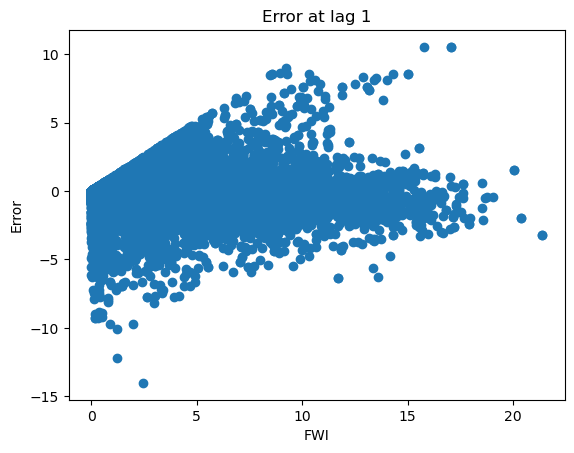

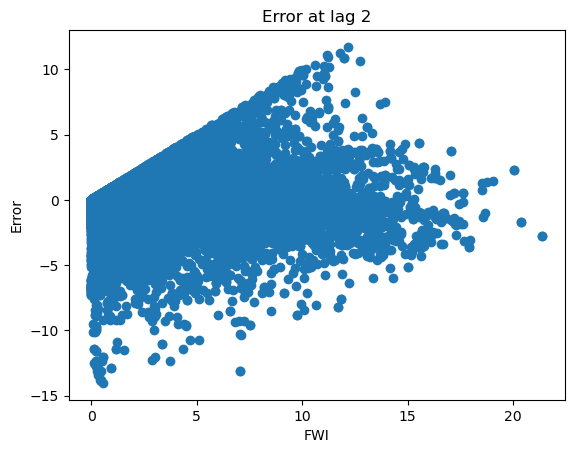

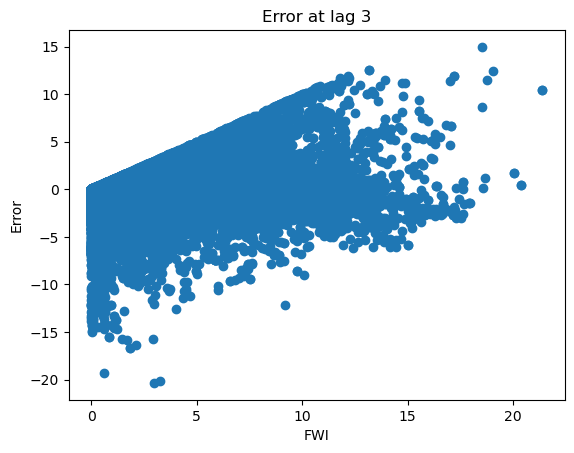

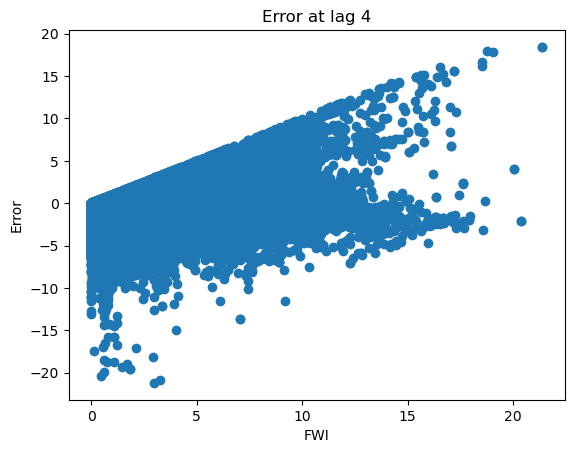

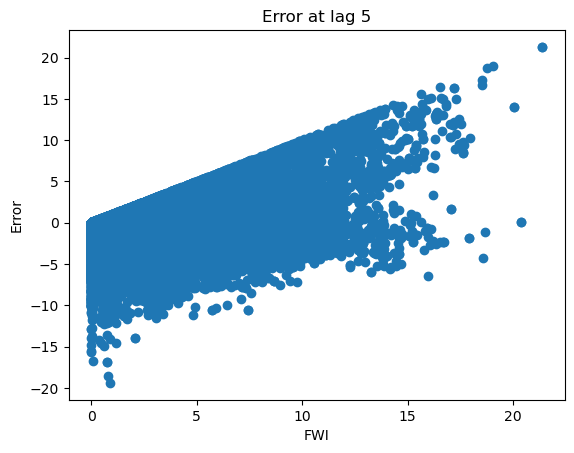

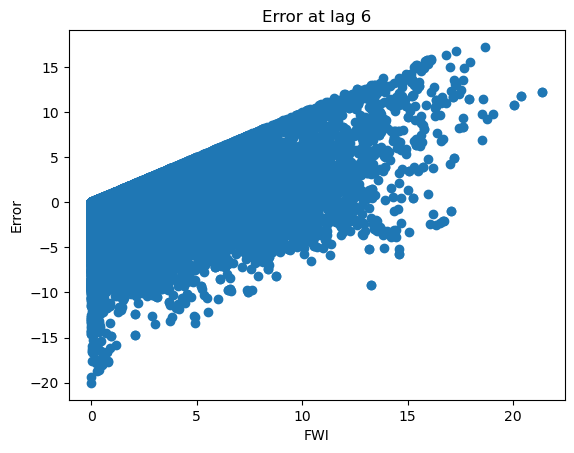

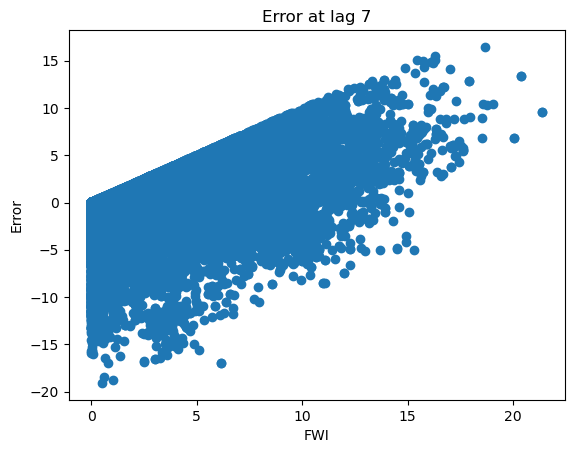

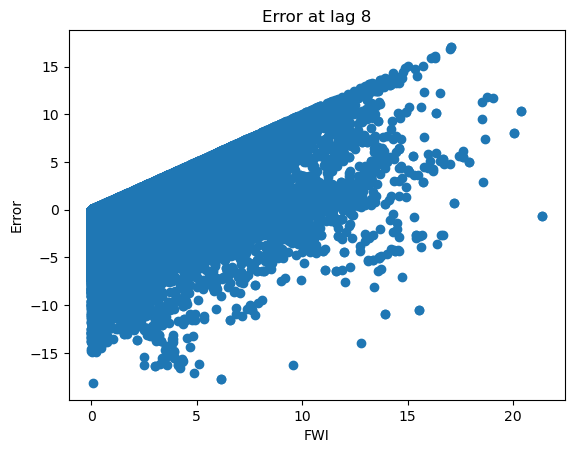

In [5]:
for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    plt.scatter(small_fire.FWI, small_fire[f"fwi_error_{i}"])
    plt.xlabel("FWI")
    plt.ylabel("Error")
    plt.title(f"Error at lag {i}")
    plt.show()

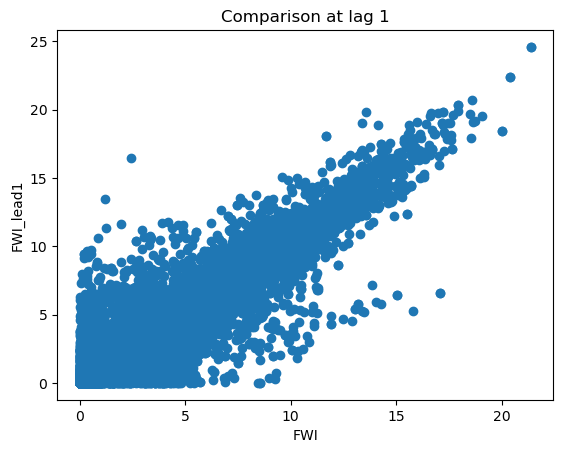

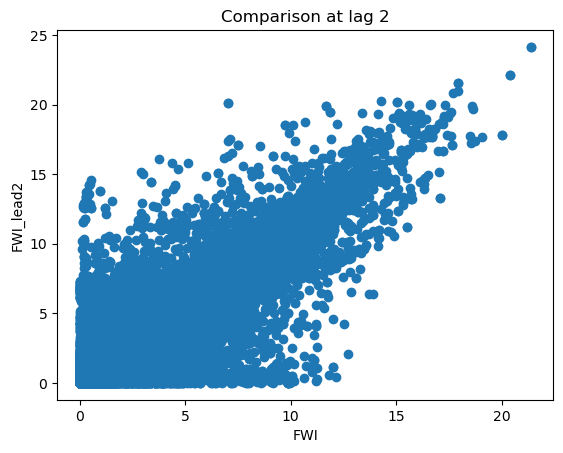

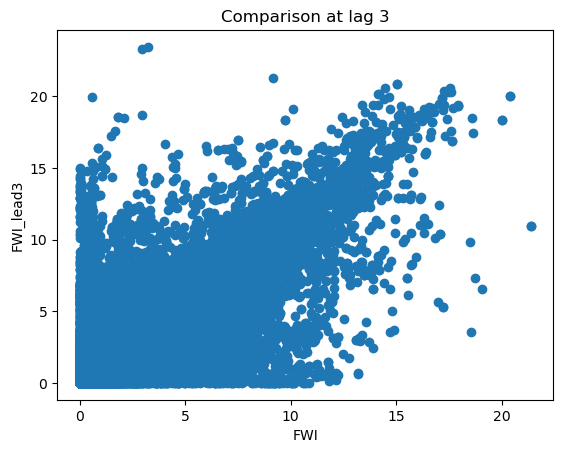

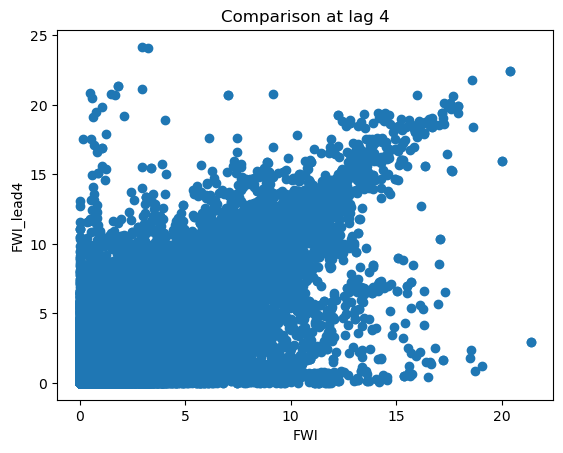

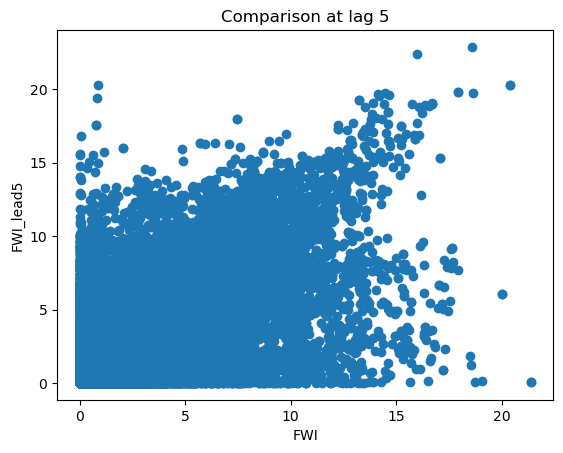

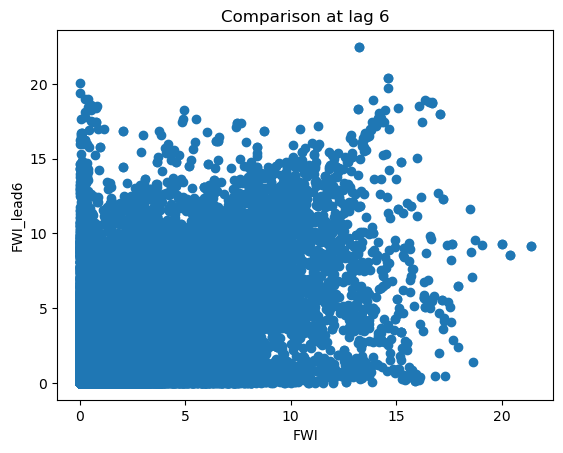

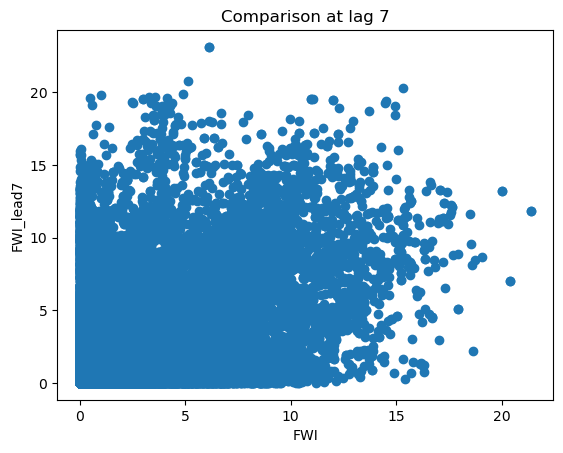

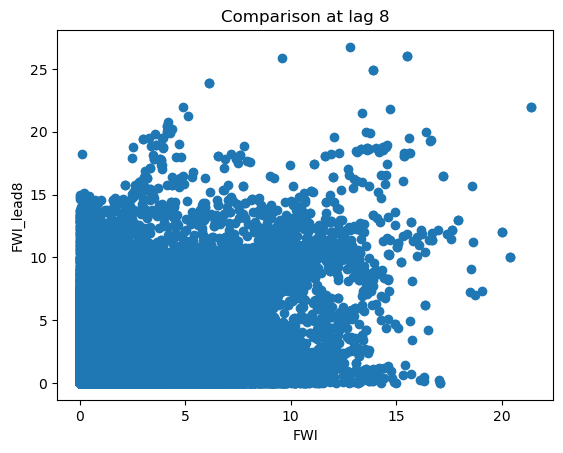

In [6]:
for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    plt.scatter(small_fire.FWI, small_fire[f"FWI_lead_{i}"])
    plt.xlabel("FWI")
    plt.ylabel(f"FWI_lead{i}")
    plt.title(f"Comparison at lag {i}")
    plt.show()

In [8]:
### Ok, see if you can get rid of duplicates for the purposes of plotting 

small_small_fire = small_fire[['GEOS-5.IMERGEARLY',
       'FWI', 'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4',
       'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8', 'pre_small_fire',
       'fwi_error_1', 'fwi_error_2', 'fwi_error_3', 'fwi_error_4',
       'fwi_error_5', 'fwi_error_6', 'fwi_error_7', 'fwi_error_8']]
small_small_fire = small_small_fire.drop_duplicates()
#small_fire.columns

In [10]:
len(small_small_fire)

41742

In [11]:
len(small_fire)

105971

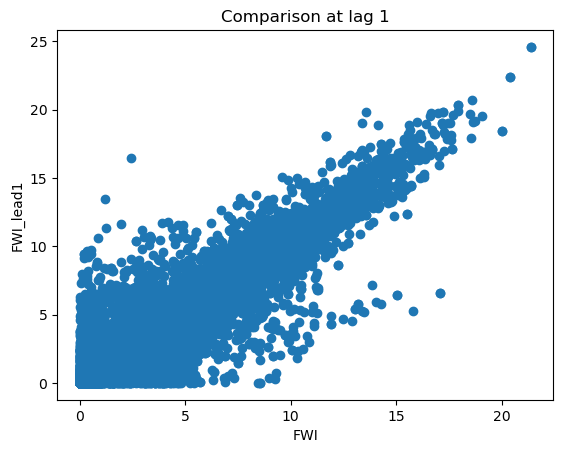

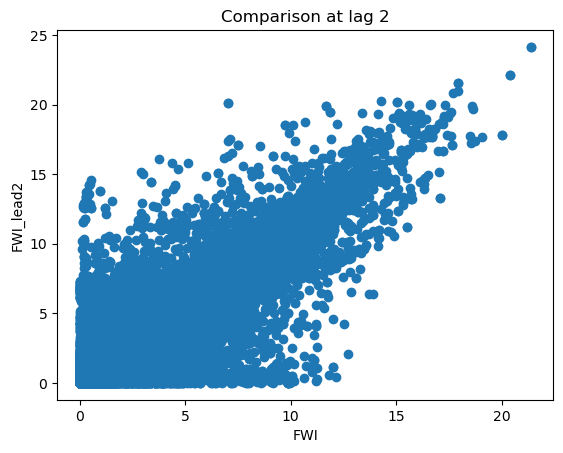

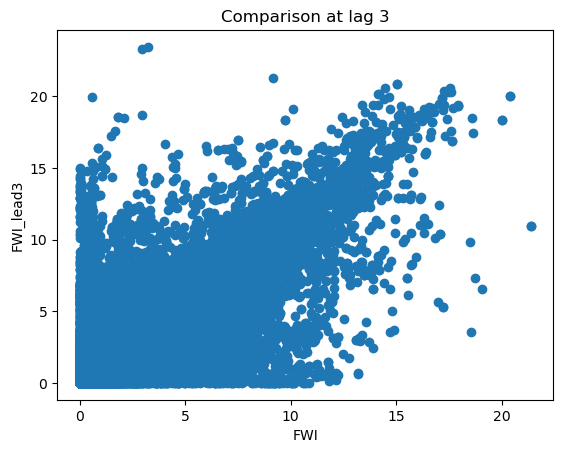

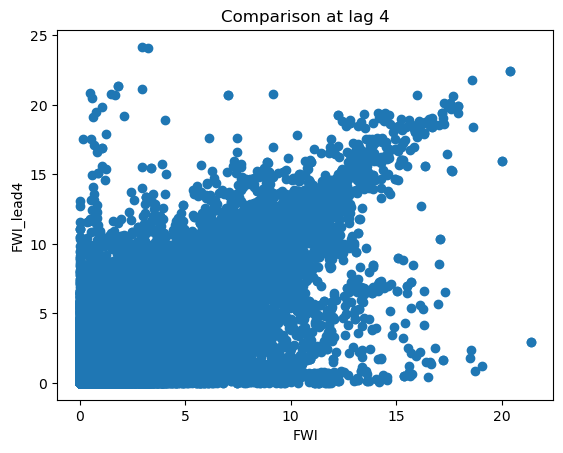

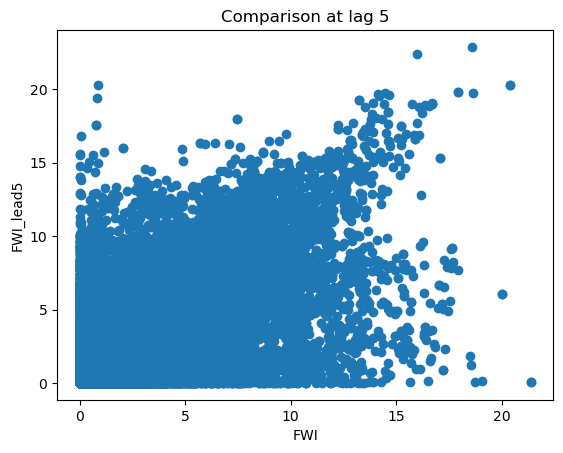

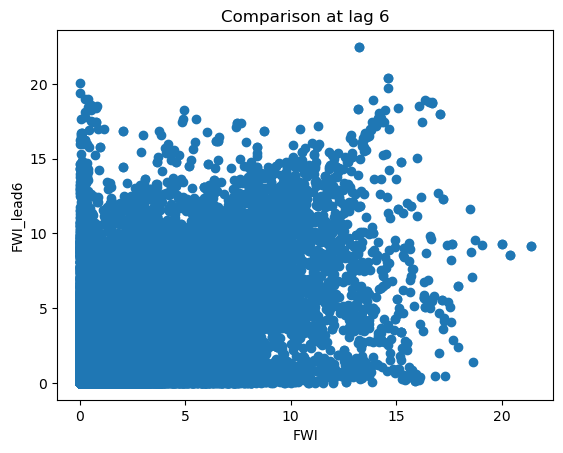

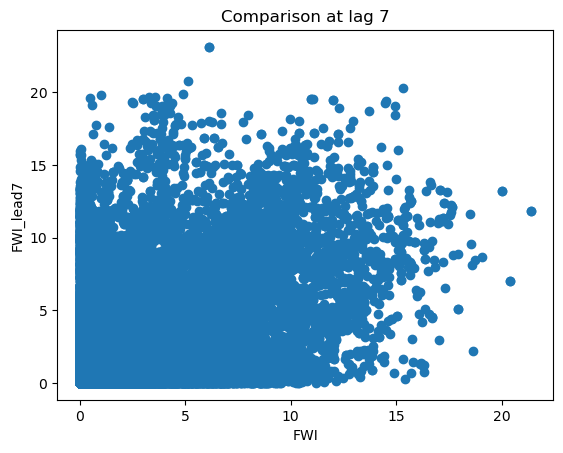

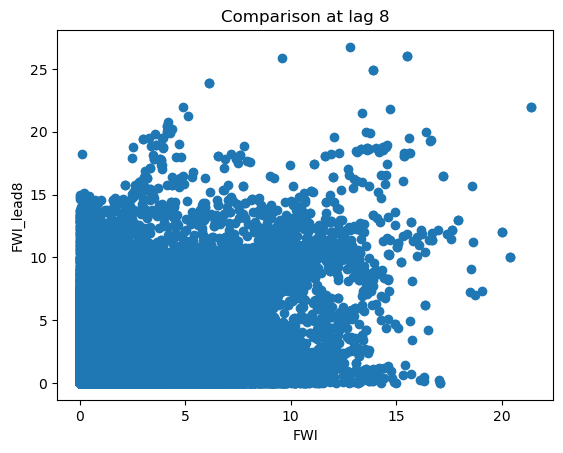

In [12]:
for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    plt.scatter(small_fire.FWI, small_fire[f"FWI_lead_{i}"])
    plt.xlabel("FWI")
    plt.ylabel(f"FWI_lead{i}")
    plt.title(f"Comparison at lag {i}")
    plt.show()

In [21]:
log_fire = small_fire
small_fire.columns
#log_fire = np.log(small_fire[['FWI', 'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3','FWI_lead_4', 'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8']] + 1)

Index(['GEOS-5.IMERGEARLY', 'FWI', 'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3',
       'FWI_lead_4', 'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8',
       'pre_fire', 'fwi_error_1', 'fwi_error_2', 'fwi_error_3', 'fwi_error_4',
       'fwi_error_5', 'fwi_error_6', 'fwi_error_7', 'fwi_error_8'],
      dtype='object')

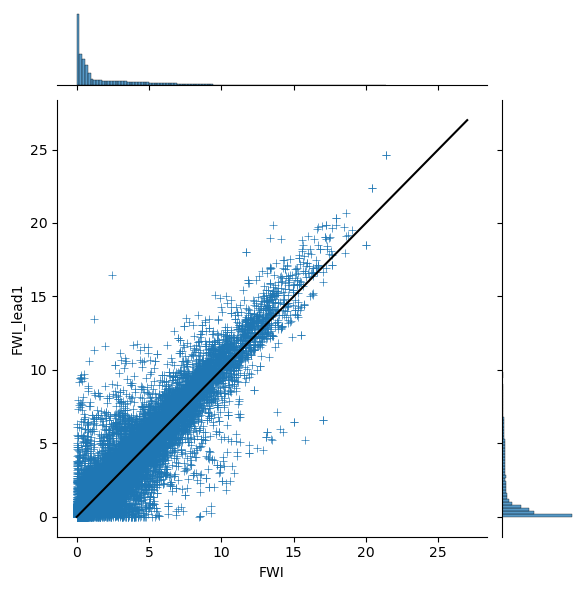

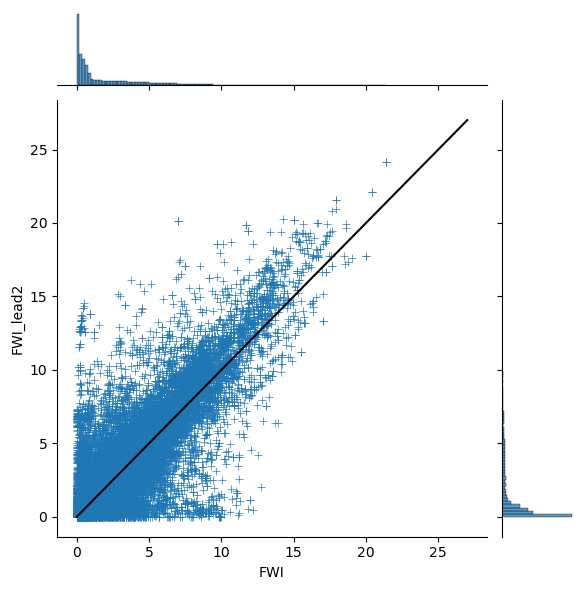

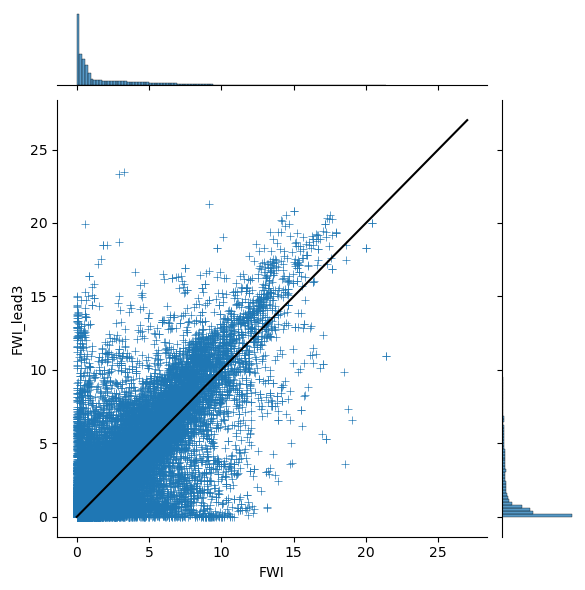

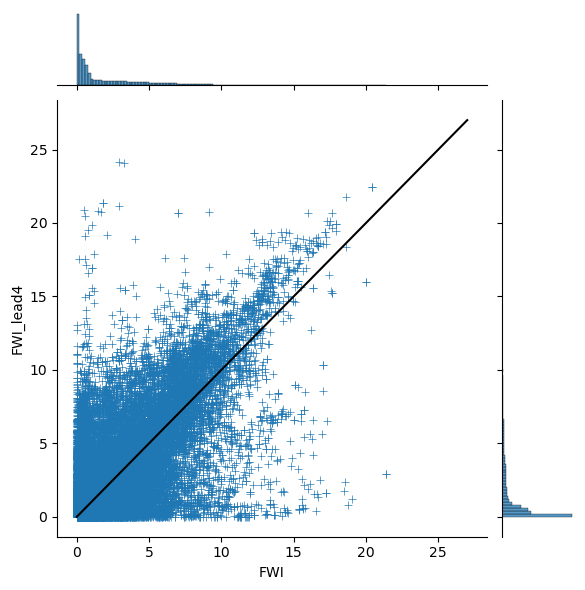

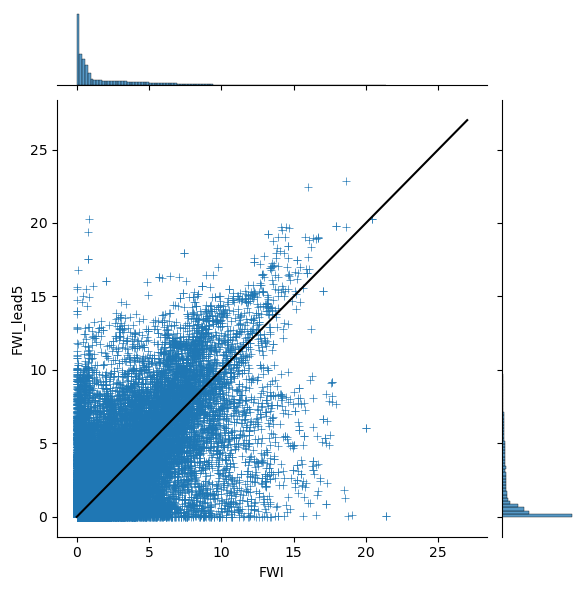

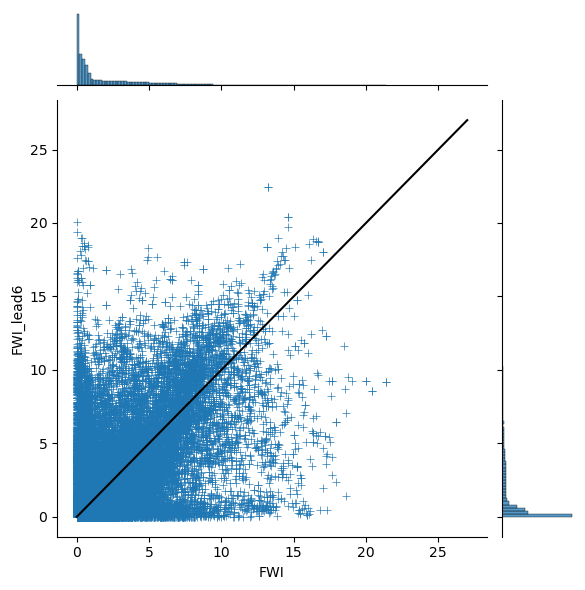

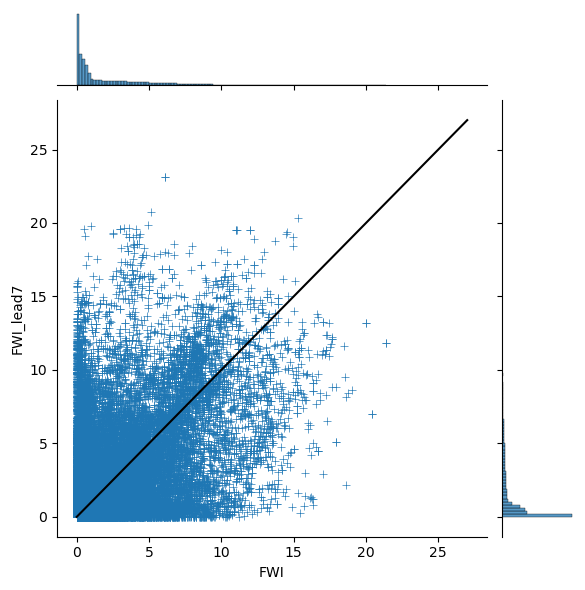

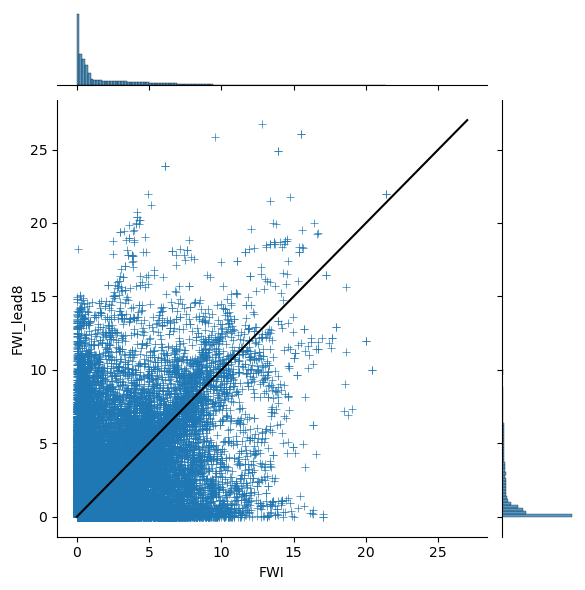

In [30]:
import seaborn as sns 

for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    sns.jointplot(data=log_fire, x="FWI", y=f"FWI_lead_{i}", marker="+") 
    plt.plot(range(0,28), range(0,28), color = "black")
    plt.xlabel("FWI")
    plt.ylabel(f"FWI_lead{i}")
    #plt.title(f"Comparison at lag {i}")
    plt.show()
    
# here "*" is used as a marker for scatterplot 

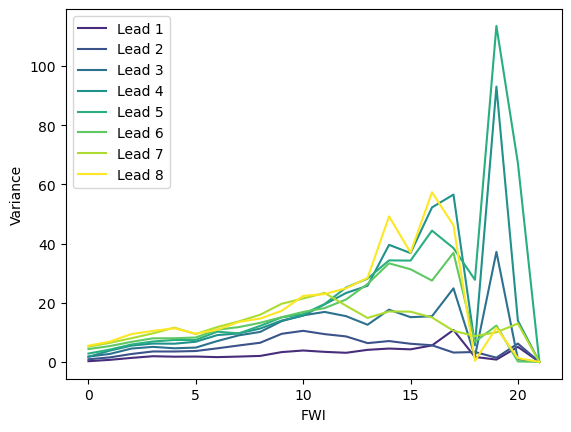

In [73]:
## Calculate the varience at different FWI and lag values
small_fire["FWI_round"] = np.round(small_fire.FWI)


#plt.plot()


#cmap = plt.get_cmap('viridis')
colors = plt.cm.viridis(np.linspace(0,1,9))

for i in range(1,9):
    test_var = small_fire.groupby("FWI_round")[f"FWI_lead_{i}"].var().reset_index()
    plt.plot(test_var.FWI_round, test_var[f"FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.xlabel("FWI")
    plt.ylabel(f"Variance")
    plt.legend()
    #plt.title(f"Comparison at lag {i}")
    #plt.show()


In [42]:
small_fire

,GEOS-5.IMERGEARLY,FWI,FWI_lead_1,FWI_lead_2,FWI_lead_3,FWI_lead_4,FWI_lead_5,FWI_lead_6,FWI_lead_7,FWI_lead_8,pre_fire,fwi_error_1,fwi_error_2,fwi_error_3,fwi_error_4,fwi_error_5,fwi_error_6,fwi_error_7,fwi_error_8,FWI_round
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,6.663517e+00,2.683968,3.278344,0.955101,0.420523,0.709179,0.674337,0.606341,2.067747e+00,0.000338,False,-0.594376,1.728868,2.263445,1.974789,2.009632,2.077627,0.616221,2.683630,2.68
110,1.437628e+01,11.418555,12.995580,14.016458,14.630502,13.414138,9.812151,8.670969,8.733346e+00,1.585756,False,-1.577025,-2.597903,-3.211947,-1.995584,1.606404,2.747586,2.685209,9.832799,11.42
113,1.141874e+01,8.719515,9.762177,10.520937,9.820648,9.241083,5.251108,5.408271,2.862681e+00,6.908187,False,-1.042662,-1.801422,-1.101134,-0.521569,3.468406,3.311243,5.856833,1.811328,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105894,1.960134e-01,0.183429,0.161515,NaN,0.238760,0.512801,NaN,NaN,NaN,NaN,False,0.021915,NaN,-0.055330,-0.329371,NaN,NaN,NaN,NaN,0.18
105895,1.812998e-07,0.000028,0.008582,NaN,NaN,0.000007,0.000749,NaN,NaN,NaN,False,-0.008554,NaN,NaN,0.000021,-0.000721,NaN,NaN,NaN,0.00
105896,2.408940e-01,0.003627,0.000077,0.000017,NaN,0.154147,0.000299,0.003384,NaN,0.009938,False,0.003550,0.003611,NaN,-0.150519,0.003328,0.000243,NaN,-0.006311,0.00
105897,NaN,NaN,NaN,NaN,NaN,NaN,0.096319,0.000073,3.579051e-07,0.000288,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
